## Import Libraries

Code reference from langchain academy course

In [4]:
from typing_extensions import TypedDict
from typing import Literal, Annotated

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, RemoveMessage, trim_messages, convert_to_messages
from langchain_core.pydantic_v1 import BaseModel, validator, ValidationError
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph_sdk import get_client

import sqlite3
import random
from operator import add
from dataclasses import dataclass
from IPython.display import display, Image
from dotenv import load_dotenv

load_dotenv(override=True)

True

# Intro

## Simple Graph

### State

State are structured data flowing between edges
Nodes are function that process and change state

In [8]:
class State(TypedDict):
    graph_state: str

In [4]:
def node1(state: State) -> str:
    print("=== Node 1 ===")
    return {"graph_state": state['graph_state'] + " I invest in"}

def node2(state: State) -> str:
    print("=== Node 2 ===")
    return {"graph_state": state['graph_state'] + " Stocks"}

def node3(state: State) -> str:
    print("=== Node 3 ===")
    return {"graph_state": state['graph_state'] + " Crypto"}

### Edge

Connecting state

In [5]:
# Conditional edge

def decide_investment(state: State) -> Literal["node2", "node3"]:
    print("=== Decision Node ===")
    
    input = state['graph_state']
    
    if random.random() < 0.5:
        return "node2"
    else:
        return "node3"

### Graph

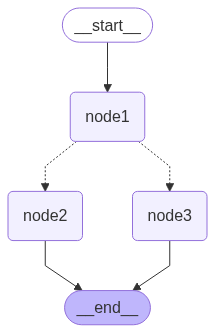

In [6]:
# Define the graph
builder = StateGraph(State)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)

# Set entrypoint
# builder.set_entry_point("node1")

# Logic
builder.add_edge(START, "node1")
builder.add_conditional_edges("node1", decide_investment)
builder.add_edge("node2", END)
builder.add_edge("node3", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"graph_state": "Hello, "})

=== Node 1 ===
=== Decision Node ===
=== Node 3 ===


{'graph_state': 'Hello,  I invest in Crypto'}

## Chain

### Messages

In [2]:
messages = [
    AIMessage(content="Do you invest in Stock Market?", name="Model"),
    HumanMessage(content="Yes, that's right", name="Human"),
    AIMessage(content="Nice, what would you like to learn", name="Model"),
    HumanMessage(content="I would like to learn about financial statement", name="Human"),   
]

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

Do you invest in Stock Market?
================================ Human Message =================================
Name: Human

Yes, that's right
================================== Ai Message ==================================
Name: Model

Nice, what would you like to learn
================================ Human Message =================================
Name: Human

I would like to learn about financial statement


### Chat Models

In [3]:
llm = ChatOpenAI(model="gpt-4o-mini")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [4]:
print(result.content)

Financial statements are crucial for understanding a company's financial health and making informed investment decisions. Here are the three primary financial statements you should be familiar with:

1. **Income Statement**: 
   - Also known as the profit and loss statement, it summarizes a company's revenues and expenses over a specific period, usually a quarter or a year.
   - Key components:
     - **Revenue**: The total income generated from sales of goods or services.
     - **Cost of Goods Sold (COGS)**: The direct costs attributable to the production of the goods sold by the company.
     - **Gross Profit**: Revenue minus COGS.
     - **Operating Expenses**: Costs required to run the business (such as selling, general, and administrative expenses).
     - **Net Income**: The profit after all expenses, taxes, and costs have been deducted from total revenue.

2. **Balance Sheet**: 
   - A snapshot of a company's financial position at a specific point in time, detailing assets, lia

In [5]:
result.response_metadata

{'token_usage': {'completion_tokens': 541,
  'prompt_tokens': 54,
  'total_tokens': 595,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-mini-2024-07-18',
 'system_fingerprint': 'fp_51db84afab',
 'id': 'chatcmpl-C8ILNZYubVGo9zLQTmvZHVQ3NkHBf',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

### Tools

In [6]:
# Simple tool function
def multiply(a: int, b: int) -> int:
    return a * b

llm_tool = llm.bind_tools([multiply])

In [7]:
tool_call = llm_tool.invoke([HumanMessage(content="What is 50 x 12?")])

In [8]:
tool_call.additional_kwargs['tool_calls']

[{'id': 'call_OfUsCwhME1AfcE4qfXgDAZXK',
  'function': {'arguments': '{"a":50,"b":12}', 'name': 'multiply'},
  'type': 'function'}]

In [9]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 50, 'b': 12},
  'id': 'call_OfUsCwhME1AfcE4qfXgDAZXK',
  'type': 'tool_call'}]

### MessagesState + MemorySaver checkpoint

In [ ]:
# Example add_messages with langgraph.graph.messages
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='e278be8e-e4a8-48a5-bc93-48e12712f88d'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='8c3d28f0-73e1-402b-aff1-71dd2b38242e'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='6882c5b8-e92a-4158-8039-1c48ec52d96c')]

In [12]:
class MessageState(MessagesState):
    pass

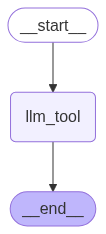

In [30]:
memory = MemorySaver()

def tooling_llm(state: MessageState):
    return {"messages": [llm_tool.invoke(state["messages"])]}

builder = StateGraph(MessageState)
builder.add_node("llm_tool", tooling_llm)
builder.add_edge(START, "llm_tool")
builder.add_edge("llm_tool", END)

graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
config = {"configurable": {"thread_id": "BangDer"}}

In [32]:
message = graph.invoke({"messages": [HumanMessage(content="Hello")]}, config=config)

In [33]:
for m in message['messages']:
    print(m.content)

Hello
Hello! How can I assist you today?


In [34]:
message = graph.invoke({"messages": [HumanMessage(content="What is Jakarta most visited mall")]}, config=config)

In [35]:
for m in message['messages']:
    print(m.content)

Hello
Hello! How can I assist you today?
What is Jakarta most visited mall
The most visited mall in Jakarta is often considered to be "Grand Indonesia." It is a large shopping complex that offers a wide range of shopping, dining, and entertainment options. Grand Indonesia is known for its upscale brands, diverse food choices, and vibrant atmosphere, making it a popular destination for both locals and tourists. Other notable malls in Jakarta include Plaza Indonesia and Mall Taman Anggrek.


In [46]:
state = graph.get_state(config=config)
for message in state.values['messages']:
    print(message.content)

Hello
Hello! How can I assist you today?
What is Jakarta most visited mall
The most visited mall in Jakarta is often considered to be "Grand Indonesia." It is a large shopping complex that offers a wide range of shopping, dining, and entertainment options. Grand Indonesia is known for its upscale brands, diverse food choices, and vibrant atmosphere, making it a popular destination for both locals and tourists. Other notable malls in Jakarta include Plaza Indonesia and Mall Taman Anggrek.


## Router

In [19]:
class MessageState(MessagesState):
    pass

def multiply(a: int, b: int) -> int:
    """Multiply a and b"""
    return a * b

llm = ChatOpenAI(model="gpt-4o-mini")
llm_tool = llm.bind_tools([multiply])

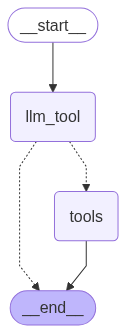

In [27]:
def tool_with_llm(state: MessageState):
    return {"messages": [llm_tool.invoke(state["messages"])]}

memory = MemorySaver()
builder = StateGraph(MessageState)
builder.add_node("llm_tool", tool_with_llm)
builder.add_node("tools", ToolNode([multiply]))

builder.add_edge(START, "llm_tool")
builder.add_conditional_edges("llm_tool", tools_condition)
builder.add_edge("tools", END)

graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
config = {"configurable": {"thread_id": "User2"}}

In [ ]:
messages = [HumanMessage(content="What is 50 x 12?")]
result = graph.invoke({"messages": messages}, config=config)

In [36]:
messages = [HumanMessage(content="Explain multiplier for 5 years kids")]
result = graph.invoke({"messages": messages}, config=config)

In [ ]:
for m in result['messages']:
    print(m.content) 

What is 50 x 12?

600
Explain multiplier for 5 years kids
A multiplier is like a magic number that helps us add the same number many times. 

Imagine you have 5 groups of 2 apples. Instead of counting each apple one by one, you can use a multiplier to make it faster. If you say "2 apples" and then "5 groups," you can find out how many apples there are in total by multiplying:

- So, 2 apples in each group × 5 groups = 10 apples.

This way, multiplying helps us find big numbers quickly without counting everything one by one!


## Agent

In [5]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_tools = llm.bind_tools(tools)

In [7]:
sys_prompt = SystemMessage(content="You are a helpful assistant tasked with writing performing arithmetic on a set of inputs.")
def assistant(state: MessagesState):
    return {"messages": [llm_tools.invoke([sys_prompt] + state["messages"])]}

The main idea of agent is we can node back to assistant node to process next tool if needed

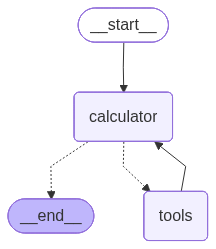

In [33]:
memory = MemorySaver()

builder = StateGraph(MessagesState)
builder.add_node("calculator", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "calculator")
builder.add_conditional_edges("calculator", tools_condition)
builder.add_edge("tools", "calculator")
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
config = {"configurable": {"thread_id": "User3"}}
messages = [HumanMessage(content="Add 10 and 50 then multiply with 5 then divide with 2")]
result = graph.invoke({"messages": messages}, config=config)

In [35]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Add 10 and 50 then multiply with 5 then divide with 2
================================== Ai Message ==================================
Tool Calls:
  add (call_OqduzNisLVGplpHUbkQKiR99)
 Call ID: call_OqduzNisLVGplpHUbkQKiR99
  Args:
    a: 10
    b: 50
  multiply (call_6mqcYBm7rjb6sTt2ZoDkHnUm)
 Call ID: call_6mqcYBm7rjb6sTt2ZoDkHnUm
  Args:
    a: 60
    b: 5
  divide (call_3pKIzfrWwRgcx4SYejpPh4fV)
 Call ID: call_3pKIzfrWwRgcx4SYejpPh4fV
  Args:
    a: 300
    b: 2
================================= Tool Message =================================
Name: add

60
================================= Tool Message =================================
Name: multiply

300
================================= Tool Message =================================
Name: divide

150.0
================================== Ai Message ==================================

Here's the step-by-step calculation:

1. Add 10 and 50: \(10 + 50 =

In [37]:
messages = [HumanMessage(content="Give me some fact based on that number")]
result = graph.invoke({"messages": messages}, config=config)

In [38]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

Add 10 and 50 then multiply with 5 then divide with 2
================================== Ai Message ==================================
Tool Calls:
  add (call_OqduzNisLVGplpHUbkQKiR99)
 Call ID: call_OqduzNisLVGplpHUbkQKiR99
  Args:
    a: 10
    b: 50
  multiply (call_6mqcYBm7rjb6sTt2ZoDkHnUm)
 Call ID: call_6mqcYBm7rjb6sTt2ZoDkHnUm
  Args:
    a: 60
    b: 5
  divide (call_3pKIzfrWwRgcx4SYejpPh4fV)
 Call ID: call_3pKIzfrWwRgcx4SYejpPh4fV
  Args:
    a: 300
    b: 2
================================= Tool Message =================================
Name: add

60
================================= Tool Message =================================
Name: multiply

300
================================= Tool Message =================================
Name: divide

150.0
================================== Ai Message ==================================

Here's the step-by-step calculation:

1. Add 10 and 50: \(10 + 50 =

## Deployment

In [45]:
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistant = await client.assistants.search()
assistant

[{'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'graph_id': 'agent',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'agent',
  'created_at': '2025-08-26T09:51:25.429747+00:00',
  'updated_at': '2025-08-26T09:51:25.429747+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': '228f9934-0cdd-5383-92c8-ee8422522cc2',
  'graph_id': 'router',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'router',
  'created_at': '2025-08-26T09:51:25.402920+00:00',
  'updated_at': '2025-08-26T09:51:25.402920+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': '28d99cab-ad6c-5342-aee5-400bd8dc9b8b',
  'graph_id': 'simple_graph',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'simple_graph',
  'created_at': '2025-08-26T09:51:24.294212+00:00',
  'updated_at': '2025-08-26T09:51:24.294212+00:00',
  'version': 1,
  'description': None}]

In [48]:
# We create a thread for tracking the state of our run
thread = await client.threads.create()

# Define the agent
agent = assistant[0]

In [56]:
input = {"messages": [HumanMessage(content="Add 5 and 50 then multiply by 3")]}

# Stream
async for chunk in client.runs.stream(
        thread['thread_id'],
        agent["assistant_id"],
        input=input,
        stream_mode="values",
    ):
    if chunk.data and chunk.event != "metadata":
        print(chunk.data['messages'][-1]['content'])

Add 5 and 50 then multiply by 3

165
The result of adding \(5\) and \(50\) is \(55\), and then multiplying that by \(3\) results in \(165\).


# State and Memory

## State Schema

### Typed Dict

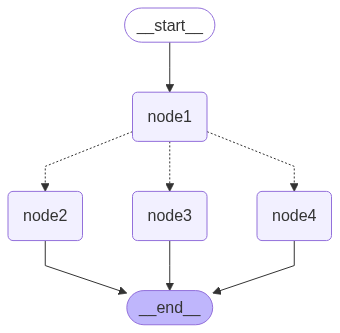

In [2]:
class TypedState(TypedDict):
    name: str
    asset: Literal["Stock", "Bonds", "Crypto"]
    
def node1(state: TypedState):
    print("===Node 1===")
    return {"name": state['name']}

def node2(state: TypedState):
    print("===Node 2===")
    return {"asset": "Stock"}

def node3(state: TypedState):
    print("===Node 2===")
    return {"asset": "Bonds"}

def node4(state: TypedState):
    print("===Node 3===")
    return {"asset": "Crypto"}


def decide_asset(state: TypedState) -> Literal["node2", "node3", "node4"]:
    prob = random.random()
    
    if prob < 0.33:
        return "node2"
    
    if prob < 0.67:
        return "node3"
    
    return "node4"

builder = StateGraph(TypedState)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)
builder.add_node("node4", node4)

builder.add_edge(START, "node1")
builder.add_conditional_edges("node1", decide_asset)
builder.add_edge("node2", END)
builder.add_edge("node3", END)
builder.add_edge("node4", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
graph.invoke({"name": "Bangder"})

===Node 1===
===Node 2===


{'name': 'Bangder', 'asset': 'Stock'}

### Dataclass

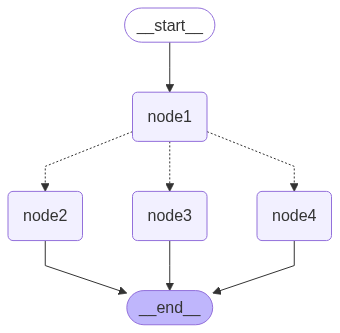

In [4]:
@dataclass
class ClassState:
    name: str
    asset: Literal["Stock", "Bonds", "Crypto"] = "Stock"

def node1(state: ClassState):
    print("===Node 1===")
    return {"name": state.name}

def node2(state: ClassState):
    print("===Node 2===")
    return {"asset": "Stock"}

def node3(state: ClassState):
    print("===Node 2===")
    return {"asset": "Bonds"}

def node4(state: ClassState):
    print("===Node 3===")
    return {"asset": "Crypto"}


def decide_asset(state: ClassState) -> Literal["node2", "node3", "node4"]:
    prob = random.random()
    
    if prob < 0.33:
        return "node2"
    
    if prob < 0.67:
        return "node3"
    
    return "node4"

builder = StateGraph(ClassState)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)
builder.add_node("node4", node4)

builder.add_edge(START, "node1")
builder.add_conditional_edges("node1", decide_asset)
builder.add_edge("node2", END)
builder.add_edge("node3", END)
builder.add_edge("node4", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
graph.invoke({"name": "Bangder", "asset": "Any"})

===Node 1===
===Node 2===


{'name': 'Bangder', 'asset': 'Stock'}

Dataclass provide type hint but they dont enforce type

### Pydantic

In [6]:
class PydanticState(BaseModel):
    name: str
    asset: Literal["Stock", "Bonds", "Crypto"] = "Stock"
    
    @validator("asset")
    def validate_asset(cls, val):
       if val not in ["Stock", "Bonds", "Crypto"]:
           raise ValueError("Asset must be Stock, Bonds, or Crypto") 
       return val
   
try:
    state = PydanticState(name="Bangder", asset="Any")
except Exception as e:
    print("Error: ",e)

Error:  1 validation error for PydanticState
asset
  unexpected value; permitted: 'Stock', 'Bonds', 'Crypto' (type=value_error.const; given=Any; permitted=('Stock', 'Bonds', 'Crypto'))


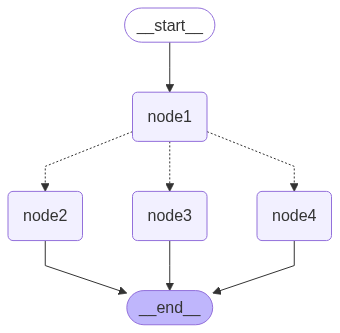

In [7]:
def node1(state: PydanticState):
    print("===Node 1===")
    return {"name": state.name}

def node2(state: PydanticState):
    print("===Node 2===")
    return {"asset": "Stock"}

def node3(state: PydanticState):
    print("===Node 2===")
    return {"asset": "Bonds"}

def node4(state: PydanticState):
    print("===Node 3===")
    return {"asset": "Crypto"}


def decide_asset(state: PydanticState) -> Literal["node2", "node3", "node4"]:
    prob = random.random()
    
    if prob < 0.33:
        return "node2"
    
    if prob < 0.67:
        return "node3"
    
    return "node4"

builder = StateGraph(PydanticState)
builder.add_node("node1", node1)
builder.add_node("node2", node2)
builder.add_node("node3", node3)
builder.add_node("node4", node4)

builder.add_edge(START, "node1")
builder.add_conditional_edges("node1", decide_asset)
builder.add_edge("node2", END)
builder.add_edge("node3", END)
builder.add_edge("node4", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
graph.invoke({"name": "Bangder", "asset": "Stock"})

===Node 1===
===Node 2===


{'name': 'Bangder', 'asset': 'Bonds'}

## State Reducer

When a node branch into > 1 node and run in parallel, which means they run in the same step of graph, they both attempt to overwrite the state on the same step, this is why state reducer came

### Reducer

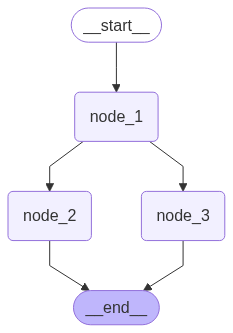

In [9]:
# Example Branching graph
class ReducerState(TypedDict):
    counter: Annotated[list[int], add]
    
def node_1(state: ReducerState):
    print("---Node 1---")
    return {"counter": [state['counter'][-1] + 1]}

def node_2(state: ReducerState):
    print("---Node 2---")
    return {"counter": [state['counter'][-1] + 2]}

def node_3(state: ReducerState):
    print("---Node 3---")
    return {"counter": [state['counter'][-1] + 3]}


builder = StateGraph(ReducerState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
graph.invoke({"counter": [1]})

---Node 1---
---Node 2---
---Node 3---


{'counter': [1, 2, 4, 5]}

In [11]:
try:
    graph.invoke({"counter": None})
except Exception as e:
    print("Error: ",e)

Error:  can only concatenate list (not "NoneType") to list


Sometimes we need to input None to the node but it leave with error, so we have to make custom reducer instead of using add

### Custom Reducer

In [16]:
def reduce_list(old_state: list | None, new_state: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        old_state (list | None): The first list to combine, or None.
        new_state (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not old_state:
        old_state = []
    if not new_state:
        new_state = []
    return old_state + new_state

class DefaultState(TypedDict):
    counter: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    counter: Annotated[list[int], reduce_list]
    messages: Annotated[list[str], reduce_list]

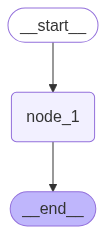

TypeError occurred: can only concatenate list (not "NoneType") to list


In [13]:
def node_1(state: DefaultState):
    print("---Node 1---")
    return {"counter": [2]}

# Build graph
builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"counter" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

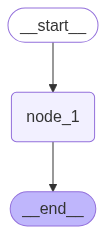

---Node 1---
{'counter': [2], 'messages': ['Bro', 'hi']}


In [22]:
# Build graph
def node_1(state: CustomReducerState):
    print("---Node 1---")
    return {"counter": [2], "messages": ["hi"]}

builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"counter" : None, "messages": ["Bro"]}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

### Messages

In [ ]:
# Both work the same things, add_messages works as reducer for messages
class CustomMessagesState(TypedDict):
    messages: Annotated[list[str], add_messages]
    key_1: str
    key_2: str
    
class ExtendedMessagesState(MessagesState):
    key_1: str
    key_2: str


In [24]:
# add messages example
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on US Stock Market.", name="User")]

new_message = AIMessage(content="Sure, I can help with that. Which asset are you interested in?", name="Model")
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='2f3b1c40-f235-4cfd-bdd4-af2db7e16427'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='5107b1bd-6334-4fc7-99c6-608bea39f6a2'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='1c68186b-178f-4e65-84fb-791f2b2460a8')]

In [25]:
# We also can overwrite the message with ID
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking for information on US Stock.", name="User", id="2")]

# New message to add
new_message = HumanMessage(content="I'm looking for information on Indo Stockk", name="User", id="2")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="I'm looking for information on Indo Stockk", additional_kwargs={}, response_metadata={}, name='User', id='2')]

In [ ]:
messages = [
    AIMessage(content="Do you invest in Stock Market?", name="Model", id="1"),
    HumanMessage(content="Yes, that's right", name="Human", id="2"),
    AIMessage(content="Nice, what would you like to learn", name="Model", id="3"),
    HumanMessage(content="I would like to learn about financial statement", name="Human", id="4"),
]

# Delete 2 recent message
delete_messages = [RemoveMessage(id = message.id) for message in messages[:-2]]

for m in messages:
    print(m)
    
print("\n")
print("====" * 40)
print("\n")

deleted_message = add_messages(messages, delete_messages)
for d in deleted_message:
    print(d)

content='Do you invest in Stock Market?' additional_kwargs={} response_metadata={} name='Model' id='1'
content="Yes, that's right" additional_kwargs={} response_metadata={} name='Human' id='2'
content='Nice, what would you like to learn' additional_kwargs={} response_metadata={} name='Model' id='3'
content='I would like to learn about financial statement' additional_kwargs={} response_metadata={} name='Human' id='4'




content='Nice, what would you like to learn' additional_kwargs={} response_metadata={} name='Model' id='3'
content='I would like to learn about financial statement' additional_kwargs={} response_metadata={} name='Human' id='4'


## Multiple Schemas

**Private State & Input Output Schema**

Somehow our data only accessible for some nodes (not for client side nor output node), think about internal nodes that pass information that isn't required in input / output nodes

Sometimes we also want to use different schemas for input and output

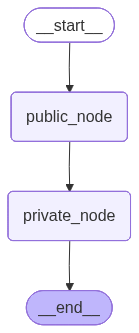

In [5]:
# Private State

class PublicState(TypedDict):
    public_num: int
    
class PrivateState(TypedDict):
    _private_num: int
    
def public_node(state: PublicState) -> PrivateState:
    return {"_private_num": state["public_num"] * 2}

def private_node(state: PrivateState) -> PublicState:
    return {"public_num": state["_private_num"] + 1}

builder = StateGraph(PublicState)
builder.add_node("public_node", public_node)
builder.add_node("private_node", private_node)

builder.add_edge(START, "public_node")
builder.add_edge("public_node", "private_node")
builder.add_edge("private_node", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
graph.invoke({"public_num": 2})

{'public_num': 5}

Only public data expose outside graph, private num don't expose outsite graph unless we return it to public

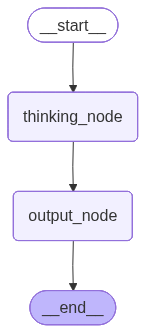

In [8]:
class InputState(TypedDict):
    question: str
    
class OutputState(TypedDict):
    answer: str
    
class InternalState(TypedDict):
    question: str
    answer: str
    notes: str
    
def thinking_node(state: InputState) -> InternalState:
    return {"question": state["question"], "answer": "Hi, may i help you?", "notes": "... thinking"}

def output_node(state: InternalState) -> OutputState:
    return {"answer": state["answer"]}

builder = StateGraph(InternalState, input_schema=InputState, output_schema=OutputState)
builder.add_node("thinking_node", thinking_node)
builder.add_node("output_node", output_node)

builder.add_edge(START, "thinking_node")
builder.add_edge("thinking_node", "output_node")
builder.add_edge("output_node", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
graph.invoke({"question": "Hi, how are you?"})

{'answer': 'Hi, may i help you?'}

Here we can customize input and output format and protect the internal state from being expose

## Trim and Filter Messages

In [3]:
llm = ChatOpenAI(model="gpt-4o-mini")

### Reducer

A challenge when working with messages is managing long conversation, which result in high token usage because we pass a growing list of messages to the model. This is why we need to filter our input messages

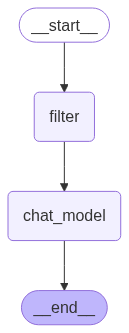

In [4]:
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages (Reference from reducer)
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
messages = [
    AIMessage(content="Do you invest in Stock Market?", name="Model", id="1"),
    HumanMessage(content="Yes, that's right", name="Human", id="2"),
    AIMessage(content="Nice, what would you like to learn", name="Model", id="3"),
    HumanMessage(content="I would like to learn about financial statement", name="Human", id="4"),
]

result = graph.invoke({"messages": messages})
for message in result['messages']:
    message.pretty_print()

================================== Ai Message ==================================
Name: Model

Nice, what would you like to learn
================================ Human Message =================================
Name: Human

I would like to learn about financial statement
================================== Ai Message ==================================

Financial statements are formal records of the financial activities and position of a business, organization, or individual. They provide a summary of the financial transactions over a specific period and are used to make informed decisions. The four main types of financial statements are:

1. **Balance Sheet**: This statement provides a snapshot of an entity's assets, liabilities, and equity at a specific point in time. It follows the accounting equation:
   \[
   \text{Assets} = \text{Liabilities} + \text{Equity}
   \]
   - **Assets** include anything of value that the company owns—cash, inventory, property, equipment, etc.
   - **Liabil

### Filtering Message

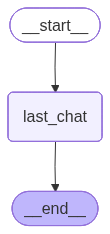

In [7]:
def last_chat_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"][-1:])}

builder = StateGraph(MessagesState)
builder.add_node("last_chat", last_chat_node)
builder.add_edge(START, "last_chat")
builder.add_edge("last_chat", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
messages.append(result['messages'][-1])
messages.append(HumanMessage(content="Tell me more about Statement of changes in equity", name="Human"))

In [9]:
for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: Model

Do you invest in Stock Market?
================================ Human Message =================================
Name: Human

Yes, that's right
================================== Ai Message ==================================
Name: Model

Nice, what would you like to learn
================================ Human Message =================================
Name: Human

I would like to learn about financial statement
================================== Ai Message ==================================

Financial statements are formal records of the financial activities and position of a business, organization, or individual. They provide a summary of the financial transactions over a specific period and are used to make informed decisions. The four main types of financial statements are:

1. **Balance Sheet**: This statement provides a snapshot of an entity's assets, liabilities, and equity at a specific 

In [10]:
result = graph.invoke({"messages": messages})
for message in result['messages']:
    message.pretty_print()

================================== Ai Message ==================================
Name: Model

Do you invest in Stock Market?
================================ Human Message =================================
Name: Human

Yes, that's right
================================== Ai Message ==================================
Name: Model

Nice, what would you like to learn
================================ Human Message =================================
Name: Human

I would like to learn about financial statement
================================== Ai Message ==================================

Financial statements are formal records of the financial activities and position of a business, organization, or individual. They provide a summary of the financial transactions over a specific period and are used to make informed decisions. The four main types of financial statements are:

1. **Balance Sheet**: This statement provides a snapshot of an entity's assets, liabilities, and equity at a specific 

### Trimming messages

With trimming, we can set number of token needed

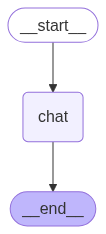

In [26]:
def chat_node(state: MessagesState):
    messages = trim_messages(
        state["messages"],
        max_tokens=100,
        strategy="last",
        token_counter=ChatOpenAI(model="gpt-4o"),
        allow_partial=False
    )
    return {"messages": llm.invoke(messages)}

builder = StateGraph(MessagesState)
builder.add_node("chat", chat_node)
builder.add_edge(START, "chat")
builder.add_edge("chat", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [27]:
messages.append(result['messages'][-1])
messages.append(HumanMessage(content="What mistake do people usually did while analyze Income Statement"))
messages

[AIMessage(content='Do you invest in Stock Market?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="Yes, that's right", additional_kwargs={}, response_metadata={}, name='Human', id='2'),
 AIMessage(content='Nice, what would you like to learn', additional_kwargs={}, response_metadata={}, name='Model', id='3'),
 HumanMessage(content='I would like to learn about financial statement', additional_kwargs={}, response_metadata={}, name='Human', id='4'),
 AIMessage(content="Financial statements are formal records of the financial activities and position of a business, organization, or individual. They provide a summary of the financial transactions over a specific period and are used to make informed decisions. The four main types of financial statements are:\n\n1. **Balance Sheet**: This statement provides a snapshot of an entity's assets, liabilities, and equity at a specific point in time. It follows the accounting equation:\n   \\[\n   \\text{Asse

In [24]:
trim_messages(
    messages,
    max_tokens=100,
    strategy="last",
    token_counter=ChatOpenAI(model="gpt-4o"),
    allow_partial=False
)

[HumanMessage(content='What mistake do people usually did while analyze Income Statement', additional_kwargs={}, response_metadata={})]

In [28]:
result = graph.invoke({"messages": messages})
for message in result['messages']:
    message.pretty_print()

================================== Ai Message ==================================
Name: Model

Do you invest in Stock Market?
================================ Human Message =================================
Name: Human

Yes, that's right
================================== Ai Message ==================================
Name: Model

Nice, what would you like to learn
================================ Human Message =================================
Name: Human

I would like to learn about financial statement
================================== Ai Message ==================================

Financial statements are formal records of the financial activities and position of a business, organization, or individual. They provide a summary of the financial transactions over a specific period and are used to make informed decisions. The four main types of financial statements are:

1. **Balance Sheet**: This statement provides a snapshot of an entity's assets, liabilities, and equity at a specific 

## Chatbot + Memory

We will create an chatbot agent which can summarize conversation if there are lots of message to save up tokens, after summarizing, we can delete previous message (it's like compress a lot of token messages)

In [ ]:
# Usecase for RAM memory, auto delete when program is finished or connection is closed
conn = sqlite3.connect(":memory:")

# Connect to local database
conn = sqlite3.connect("db/memory.db", check_same_thread=False)

# Checkpointer
memory = MemorySaver() # -> No database, purely using python dict
memory = SqliteSaver(conn)

In [4]:
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

class State(MessagesState):
    summary: str
    

def call_model(state: State):
    summary = state.get("summary", "")
    
    if summary:
        system_message = f"Summary from previous conversation : {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:   
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    """Summarize the conversation and delete previous messages only left 2 newest messages"""
    summary = state.get("summary", "")
    
    if summary: 
        # if summary exist we extend the conversation
        summary_message = (
            f"This is summary of previous conversation : {summary}\n"
            "Extend those summary with new messages below: "
        )
    else: 
        summary_message = "\nCreate summary of this conversation above: "
        
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    deleted_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": deleted_messages}

def should_summarize(state: State) -> Literal["summarize_conversation", END]: # type: ignore
    """When the message get longer (more than 4) it should summarize the conversation"""
    messages = state["messages"]

    if len(messages) > 4:
        return "summarize_conversation"
     
    return END

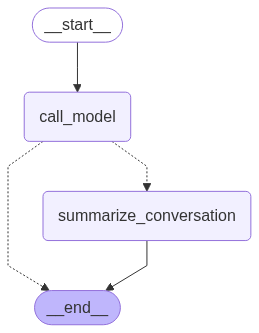

In [30]:
builder = StateGraph(State)
builder.add_node("call_model", call_model)
builder.add_node("summarize_conversation", summarize_conversation)

builder.add_edge(START, "call_model")
builder.add_conditional_edges("call_model", should_summarize)
builder.add_edge("summarize_conversation", END)

graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
config = {"configurable": {"thread_id": "TestBot"}}

In [ ]:
input_message = HumanMessage(content="I want to learn about flow and orderbook analysis on stock")
response = graph.invoke({"messages": [input_message]}, config=config)

input_message = HumanMessage(content="Does those method has relationship with smart money concept?")
response = graph.invoke({"messages": [input_message]}, config=config)

for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

I want to learn about flow and orderbook analysis on stock
================================== Ai Message ==================================

Flow and order book analysis are important concepts in trading and investing, particularly in the context of stocks and other financial instruments. Here’s a breakdown of both concepts:

### Flow Analysis

**Flow analysis** refers to the study of the buying and selling activity in the market. It involves understanding the volume and direction of trades to gauge market sentiment and potential price movements. Here are some key components:

1. **Volume**: The number of shares traded over a specific period. High volume can indicate strong interest in a stock, while low volume may suggest a lack of interest.

2. **Order Flow**: This refers to the actual buy and sell orders that are being placed in the market. Analyzing order flow can help traders understand the intention

In [42]:
graph.get_state(config = config).values.get("summary", "")

''

In [43]:
input_message = HumanMessage(content="Do you think risk management is important?")
response = graph.invoke({"messages": [input_message]}, config=config)

In [44]:
print(graph.get_state(config = config).values.get("summary", ""))

In this conversation, we discussed the concepts of flow and order book analysis in stock trading, highlighting their importance in understanding market dynamics and the behavior of "smart money" (institutional investors). Flow analysis involves studying buying and selling activity to gauge market sentiment, while order book analysis provides a real-time view of buy and sell orders, revealing liquidity and potential support/resistance levels.

We also explored the relationship between these analyses and smart money, emphasizing how traders can use flow and order book data to align their strategies with institutional investors. Additionally, we underscored the critical importance of risk management in trading and investing. Effective risk management helps preserve capital, maintain emotional control, ensure consistency, and adapt to market volatility. It involves techniques such as position sizing, setting stop-loss orders, and diversifying investments, all aimed at minimizing losses and

In [8]:
graph.get_state(config = config)

StateSnapshot(values={'messages': [HumanMessage(content='Do you think risk management is important?', additional_kwargs={}, response_metadata={}, id='0e815ca3-bda6-4b00-a8f1-0cc74ee418fb'), AIMessage(content='Yes, risk management is critically important in trading and investing. It serves as a foundational element for long-term success in the financial markets. Here are several reasons why risk management is essential:\n\n### 1. **Preservation of Capital**\n   - The primary goal of risk management is to protect your capital. By implementing effective risk management strategies, you can minimize losses and ensure that you have enough capital to continue trading or investing over the long term.\n\n### 2. **Emotional Control**\n   - Trading can be emotionally taxing, especially during periods of high volatility. A solid risk management plan helps traders stick to their strategies and avoid making impulsive decisions based on fear or greed.\n\n### 3. **Consistency**\n   - Effective risk ma

# UX + Human in the Loop

## Streaming

Using chatbot graph

Notes:

There are 2 ways of streaming `.stream` and `.astream` are sync and async method for streaming result

Langgraph also support 2 streaming mode for state:
- `values`: return full state of the graph each time the node called
- `update`: update the state of the graph after each time the node called



![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

### Example .stream

In [11]:
config = {"configurable": {"thread_id": "Streaming"}}

In [12]:
input = HumanMessage(content="How do ETF works?")
for message in graph.stream({"messages": [input]}, config=config, stream_mode="updates"):
    print(message)

{'call_model': {'messages': AIMessage(content='Exchange-Traded Funds (ETFs) are investment funds that are traded on stock exchanges, similar to individual stocks. They are designed to track the performance of a specific index, commodity, currency, or a mix of various asset classes. Here’s how they work:\n\n### 1. Structure of ETFs\n- **Composition**: An ETF holds a collection of assets, such as stocks, bonds, or commodities. For example, a stock ETF might track the S&P 500 index by holding shares of the companies that make up that index.\n- **Shares**: Investors buy shares of the ETF, which represent a proportional ownership of the underlying assets.\n\n### 2. Trading\n- **Exchange-Traded**: ETFs are bought and sold on stock exchanges throughout the trading day, just like individual stocks. This allows for real-time pricing and liquidity.\n- **Market Price**: The price of an ETF share fluctuates throughout the day based on supply and demand, but it generally stays close to the net asse

In [25]:
message["call_model"]['messages'].model_dump()

{'content': 'Exchange-Traded Funds (ETFs) are investment funds that are traded on stock exchanges, similar to individual stocks. They are designed to track the performance of a specific index, commodity, currency, or a mix of various asset classes. Here’s how they work:\n\n### 1. Structure of ETFs\n- **Composition**: An ETF holds a collection of assets, such as stocks, bonds, or commodities. For example, a stock ETF might track the S&P 500 index by holding shares of the companies that make up that index.\n- **Shares**: Investors buy shares of the ETF, which represent a proportional ownership of the underlying assets.\n\n### 2. Trading\n- **Exchange-Traded**: ETFs are bought and sold on stock exchanges throughout the trading day, just like individual stocks. This allows for real-time pricing and liquidity.\n- **Market Price**: The price of an ETF share fluctuates throughout the day based on supply and demand, but it generally stays close to the net asset value (NAV) of the underlying as

### Streaming Token

In [26]:
config = {"configurable": {"thread_id": "Streaming_token"}}

In [40]:
input_message = HumanMessage(content="Tell me about sesquehanna capital management")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: call_model. Type: on_chain_start. Name: call_model
Node: call_model. Type: on_chat_model_start. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model. Type: on_chat_model_stream. Name: ChatOpenAI
Node: call_model

In [44]:
# To stream only the content
stream_node = "call_model"

input_message = HumanMessage(content="Tell me about goldman sachs")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    if event['event'] == "on_chat_model_stream" and event['metadata'].get("langgraph_node", "") == stream_node:
        print(event['data']['chunk'].content, end="")

Goldman Sachs Group, Inc. is a leading global investment banking, securities, and investment management firm headquartered in New York City. Founded in 1869 by Marcus Goldman, the firm has established itself as one of the most influential financial institutions in the world.

### Key Areas of Business:

1. **Investment Banking**: Goldman Sachs provides advisory services for mergers and acquisitions (M&A), restructurings, and capital raising. The firm is known for its expertise in underwriting and facilitating complex financial transactions for corporations, governments, and institutions.

2. **Securities**: The firm engages in trading and market-making across various asset classes, including equities, fixed income, currencies, and commodities. Goldman Sachs plays a significant role in the global securities markets, providing liquidity and facilitating transactions.

3. **Investment Management**: Goldman Sachs offers a wide range of investment management services to institutional and in

### Langgraph API

In [ ]:
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

[{'assistant_id': '8a4ac7a4-50eb-5206-98cc-4a72345cb1f7',
  'graph_id': 'chatbot',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'chatbot',
  'created_at': '2025-08-29T16:29:23.455873+00:00',
  'updated_at': '2025-08-29T16:29:23.455873+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'graph_id': 'agent',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'agent',
  'created_at': '2025-08-29T16:29:23.451011+00:00',
  'updated_at': '2025-08-29T16:29:23.451011+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': '228f9934-0cdd-5383-92c8-ee8422522cc2',
  'graph_id': 'router',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'router',
  'created_at': '2025-08-29T16:29:23.429329+00:00',
  'updated_at': '2025-08-29T16:29:23.429329+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': '28d99cab-ad6c-5342-aee5-

In [ ]:
thread = await client.threads.create()

# Input message
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '0198f6aa-5c73-726a-b0dd-bcd464c7cbe5', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'a1f5d93c-93bb-4875-af27-b1f13d4cf45a', 'example': False}]})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'a1f5d93c-93bb-4875-af27-b1f13d4cf45a', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_uwAnAAK5UXZpABa23q37s6Tt', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_

In [56]:
async for event in client.runs.stream(thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"):
    messages = event.data.get("messages", None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print("=====" * 10)

content='Multiply 2 and 3' additional_kwargs={} response_metadata={} id='141f742b-ec28-47c4-9b42-01d4946f0810'
content='' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 238, 'output_tokens': 17, 'total_tokens': 255, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}, 'tool_calls': [{'id': 'call_9lZe5xs1fM3C37fdCf1WMA1P', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 238, 'total_tokens': 255, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-C9whtuBN5sMDW2XIDqnMSdLxHhYFj', 'service_tier': 'default', 'finish_reason': 'tool_cal

In [70]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3 then add with 3 then divide by 2")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="messages"):
    print(event)

StreamPart(event='metadata', data={'run_id': '0198f6de-4380-74b4-a667-649a57dfa392', 'attempt': 1})
StreamPart(event='messages/metadata', data={'run--77cbfeec-ff23-4e7a-a0da-cffb75897f9e': {'metadata': {'created_by': 'system', 'graph_id': 'agent', 'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca', 'run_attempt': 1, 'langgraph_version': '0.6.6', 'langgraph_api_version': '0.3.0', 'langgraph_plan': 'developer', 'langgraph_host': 'self-hosted', 'langgraph_api_url': 'http://127.0.0.1:2024', 'host': '127.0.0.1:2024', 'accept-encoding': 'gzip, deflate, br, zstd', 'connection': 'keep-alive', 'user-agent': 'langgraph-sdk-py/0.2.2', 'x-api-key': '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', 'content-length': '285', 'content-type': 'application/json', 'accept': 'text/event-stream', 'cache-control': 'no-store', 'x-request-id': '7140f6be-098c-4366-99e0-9e348f46c92d', 'langgraph_auth_user_id': '', 'langgraph_request_id': '7140f6be-098c-4366-99e0-9e348f46c92d', 'run_id': '0198f6de-4380-

We can see a few events: 

* `metadata`: metadata about the run
* `messages/complete`: fully formed message 
* `messages/partial`: chat model tokens

More docs [here](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#modemessages).

In [71]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages"):
    
    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)
    
    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")
                    
        print("-" * 50)

Metadata: Run ID - 0198f6e7-cead-755c-82c4-dca6d34e2906
--------------------------------------------------
Tool Calls:
Tool Call ID: call_kDgwkSJ0oAqiEUtMKfqmJWkU, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_kDgwkSJ0oAqiEUtMKfqmJWkU, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_kDgwkSJ0oAqiEUtMKfqmJWkU, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_kDgwkSJ0oAqiEUtMKfqmJWkU, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_kDgwkSJ0oAqiEUtMKfqmJWkU, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_kDgwkSJ0oAqiEUtMKfqmJWkU, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: cal

## Breakpoints

In [111]:
def multiply(a: int | float, b: int | float) -> int | float:
    """Multiply a and b."""
    return a * b

# This will be a tool
def add(a: int | float, b: int | float) -> int | float:
    """Adds a and b."""
    return a + b

def divide(a: int | float, b: int | float) -> int | float:
    """Divide a by b."""
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_tools = llm.bind_tools(tools)

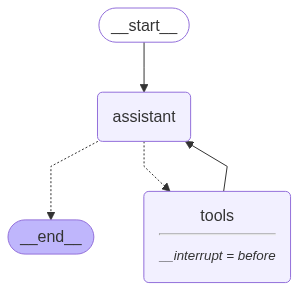

In [112]:
sys_prompt = SystemMessage(content="You are a helpful assistant tasked with writing performing arithmetic on a set of inputs.")

def assistant(state: MessagesState):
    return {"messages": [llm_tools.invoke([sys_prompt] + state["messages"])]}


builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")
builder.add_edge("assistant", END)

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"] ,checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [92]:
config = {"configurable": {"thread_id": "breakpoint"}}

In [94]:
human = HumanMessage(content="Multiply 2 and 3, then add the result with 5, then divide with 2")

for event in graph.stream({"messages": [human]}, config=config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3, then add the result with 5, then divide with 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_KvNcrZEudad2jYDTbPZO6OXI)
 Call ID: call_KvNcrZEudad2jYDTbPZO6OXI
  Args:
    a: 2
    b: 3
  add (call_h388DPgCbHqs2DpiO6HTTgDY)
 Call ID: call_h388DPgCbHqs2DpiO6HTTgDY
  Args:
    a: 6
    b: 5
  divide (call_keE2SAYV3kbOG9pF7sZF68yv)
 Call ID: call_keE2SAYV3kbOG9pF7sZF68yv
  Args:
    a: 11
    b: 2


As we see, the graph stop in Ai message step and don't continue to next tools step which means the graph has been interupted

In [79]:
state = graph.get_state(config)
print(state)
print("=====" * 20)
print(state.next)

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3 then add with 3 then divide by 2', additional_kwargs={}, response_metadata={}, id='ec7787a3-81da-4b43-8252-95de62843944'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_37lHkb3KgnnjsPPuRxqCEefL', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'call_OPR1Q2j0bToes80JvkY6LDsa', 'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 133, 'total_tokens': 183, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_1827dd0c55', 'id': 'chatcmpl-CAIGYA3Pwkvt57YwKT6Q0iAWu5ii6', 'service_tier': 'default', 'finish_reason': 't

![breakpoints.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbae7985b747dfed67775d_breakpoints1.png)

In [95]:
for event in graph.stream(None, config=config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_KvNcrZEudad2jYDTbPZO6OXI)
 Call ID: call_KvNcrZEudad2jYDTbPZO6OXI
  Args:
    a: 2
    b: 3
  add (call_h388DPgCbHqs2DpiO6HTTgDY)
 Call ID: call_h388DPgCbHqs2DpiO6HTTgDY
  Args:
    a: 6
    b: 5
  divide (call_keE2SAYV3kbOG9pF7sZF68yv)
 Call ID: call_keE2SAYV3kbOG9pF7sZF68yv
  Args:
    a: 11
    b: 2
================================= Tool Message =================================
Name: divide

5.5
================================== Ai Message ==================================

Here's how the calculations unfold:

1. **Multiply 2 and 3**:
   \[
   2 \times 3 = 6
   \]

2. **Add the result to 5**:
   \[
   6 + 5 = 11
   \]

3. **Divide by 2**:
   \[
   \frac{11}{2} = 5.5
   \]

The final result is \(5.5\).


We can use user input to validate the graph should continue or not

In [113]:
config = {"configurable": {"thread_id": "breakpoint2"}}

human = HumanMessage(content="Multiply 2 and 3, then add the result with 5, then divide with 2")
for event in graph.stream({"messages": [human]}, config=config, stream_mode="values"):
    event['messages'][-1].pretty_print()
    
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in graph.stream(None, config=config, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3, then add the result with 5, then divide with 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_R4VPKbVC84z24vCIrkJNMP01)
 Call ID: call_R4VPKbVC84z24vCIrkJNMP01
  Args:
    a: 2
    b: 3
  add (call_arNBDmKgWwarC7rw1Lw1VCtu)
 Call ID: call_arNBDmKgWwarC7rw1Lw1VCtu
  Args:
    a: 6
    b: 5
================================== Ai Message ==================================
Tool Calls:
  multiply (call_R4VPKbVC84z24vCIrkJNMP01)
 Call ID: call_R4VPKbVC84z24vCIrkJNMP01
  Args:
    a: 2
    b: 3
  add (call_arNBDmKgWwarC7rw1Lw1VCtu)
 Call ID: call_arNBDmKgWwarC7rw1Lw1VCtu
  Args:
    a: 6
    b: 5
================================= Tool Message =================================
Name: add

11
================================== Ai Message ==================================
Tool Calls:
  divide (call_RbTGUrwfNXQBUmRPjTdlZi9y)
 Call ID: ca

In [121]:
state = graph.get_state(config)

for message in state.values['messages']:
    print(message)

print("=====" * 20)
print(state.next)

content='Multiply 2 and 3, then add the result with 5, then divide with 2' additional_kwargs={} response_metadata={} id='12042e76-a448-4d41-95c1-4913a36970b7'
content='' additional_kwargs={'tool_calls': [{'id': 'call_R4VPKbVC84z24vCIrkJNMP01', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}, {'id': 'call_arNBDmKgWwarC7rw1Lw1VCtu', 'function': {'arguments': '{"a": 6, "b": 5}', 'name': 'add'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 137, 'total_tokens': 187, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_1827dd0c55', 'id': 'chatcmpl-CAIXM0sl5Vs3b4nYx4G3OzFboEb7Y', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--1ad7c4ab-7b

### With langgraph API

In [154]:
client = get_client(url="http://127.0.0.1:2024")
thread = await client.threads.create()
human = HumanMessage(content="Multiply 2 and 3, then add the result with 5, then divide with 2")
message_input = {"messages": [human]}

In [155]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input = message_input,
    stream_mode="values",
    interrupt_before=["tools"]
):
    print(f"Running event type: {chunk.event}")
    m = chunk.data.get("messages", [])
    if m:
        print(m[-1])
        print("=====" * 20)


Running event type: metadata
Running event type: values
{'content': 'Multiply 2 and 3, then add the result with 5, then divide with 2', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'c3f420f1-6b38-47a8-9781-2afb8d697a8c', 'example': False}
Running event type: values
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_11scV8NkOyJtu9x4WY5Q9mO4', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 148, 'total_tokens': 165, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-CAJAbgnLMVyLDTosqP8JtUNxLJ2Zu', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'lo

proceed the previous breakpoint by set the input with `None`

In [158]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input = None,
    stream_mode="values",
    interrupt_before=["tools"]
):
    print(f"Running event type: {chunk.event}")
    m = chunk.data.get("messages", [])
    if m:
        print(m[-1])
        print("=====" * 20)

Running event type: metadata
Running event type: values
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_sylXE53rAsP3aUjGuwXbpwQb', 'function': {'arguments': '{"a":11,"b":2}', 'name': 'divide'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 198, 'total_tokens': 215, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_46bff0e0c8', 'id': 'chatcmpl-CAJB1u4TLy9eNKSD1RjnkXz2A4e97', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--a9681911-a397-422a-a4a5-5961ce21719d-0', 'example': False, 'tool_calls': [{'name': 'divide', 'args': {'a': 11, 'b': 2}, 'id': 'call_sylXE53rAsP3aUjGuwXbpwQb', 'type': 'tool_call'}], 'invalid_tool_c

## Editing State and Human Feedback